In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Lego_Bricks",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3979 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '3673 Peg 2M']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 9 6 9 5 7 1 1 5 9 2 3 0 4 3 2 0 1 4 4 8 1 4 7 2 8 9 7 7 1 1]


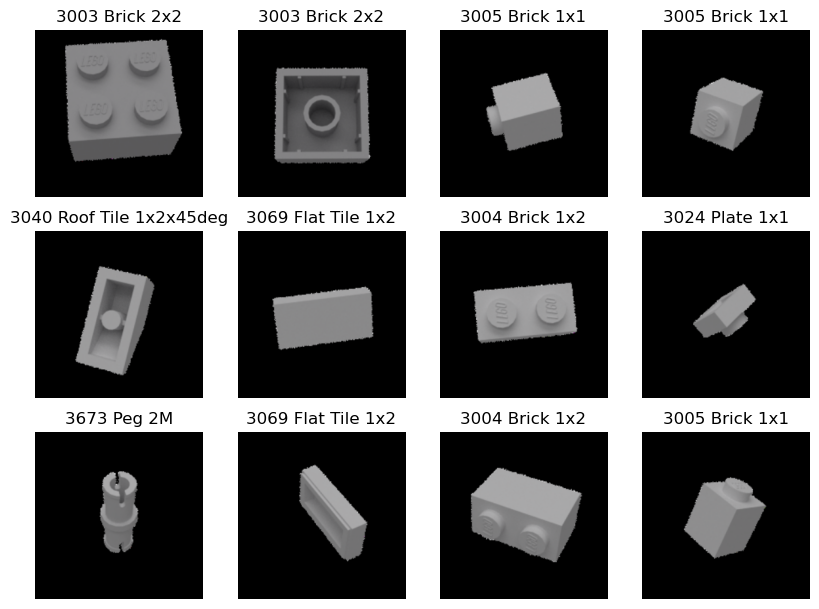

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

125

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

100

In [11]:
len(val_ds)

12

In [12]:
len(test_ds)

13

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss",
   patience=5,
   verbose=1
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
    epochs=30
)

Epoch 1/30


100/100 [==============================] - 42s 331ms/step - loss: 1.5274 - accuracy: 0.4297 - val_loss: 1.0688 - val_accuracy: 0.5677
Epoch 2/30
100/100 [==============================] - 33s 326ms/step - loss: 0.8050 - accuracy: 0.6735 - val_loss: 0.7364 - val_accuracy: 0.7057
Epoch 3/30
100/100 [==============================] - 32s 322ms/step - loss: 0.6326 - accuracy: 0.7518 - val_loss: 0.4524 - val_accuracy: 0.8411
Epoch 4/30
100/100 [==============================] - 32s 321ms/step - loss: 0.5082 - accuracy: 0.8100 - val_loss: 0.4830 - val_accuracy: 0.8125
Epoch 5/30
100/100 [==============================] - 33s 324ms/step - loss: 0.4261 - accuracy: 0.8339 - val_loss: 0.4513 - val_accuracy: 0.8542
Epoch 6/30
100/100 [==============================] - 33s 328ms/step - loss: 0.3605 - accuracy: 0.8676 - val_loss: 0.4054 - val_accuracy: 0.8411
Epoch 7/30
100/100 [==============================] - 33s 325ms/step - loss: 0.3585 - accuracy: 0.8739 - val_loss: 0.3476 - val_

In [21]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 2s 97ms/step - loss: 0.0996 - accuracy: 0.9615


In [22]:
print(early_stopping)

In [23]:
scores

[0.09956561774015427, 0.9615384340286255]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

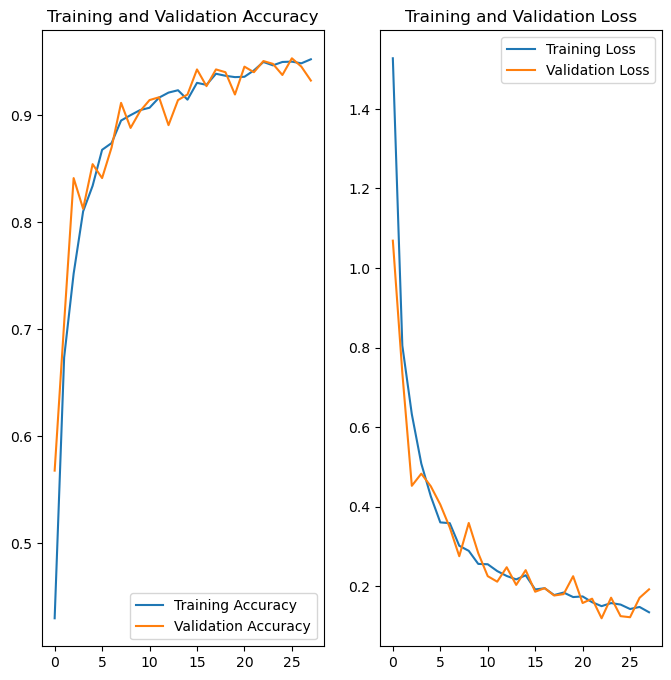

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(28), acc, label='Training Accuracy')
plt.plot(range(28), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(28), loss, label='Training Loss')
plt.plot(range(28), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 2357 Brick corner 1x2x2
1/1 [==============================] - 0s 330ms/step
predicted label: 2357 Brick corner 1x2x2


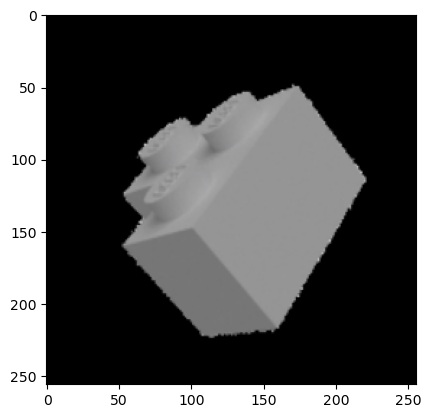

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

second image to predict
actual label: 3040 Roof Tile 1x2x45deg
1/1 [==============================] - 0s 152ms/step
predicted label: 3040 Roof Tile 1x2x45deg


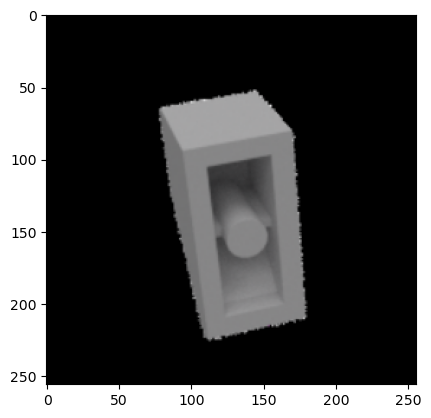

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    second_image = images_batch[1].numpy().astype('uint8')
    second_label = labels_batch[1].numpy()
    
    print("second image to predict")
    plt.imshow(second_image)
    print("actual label:",class_names[second_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


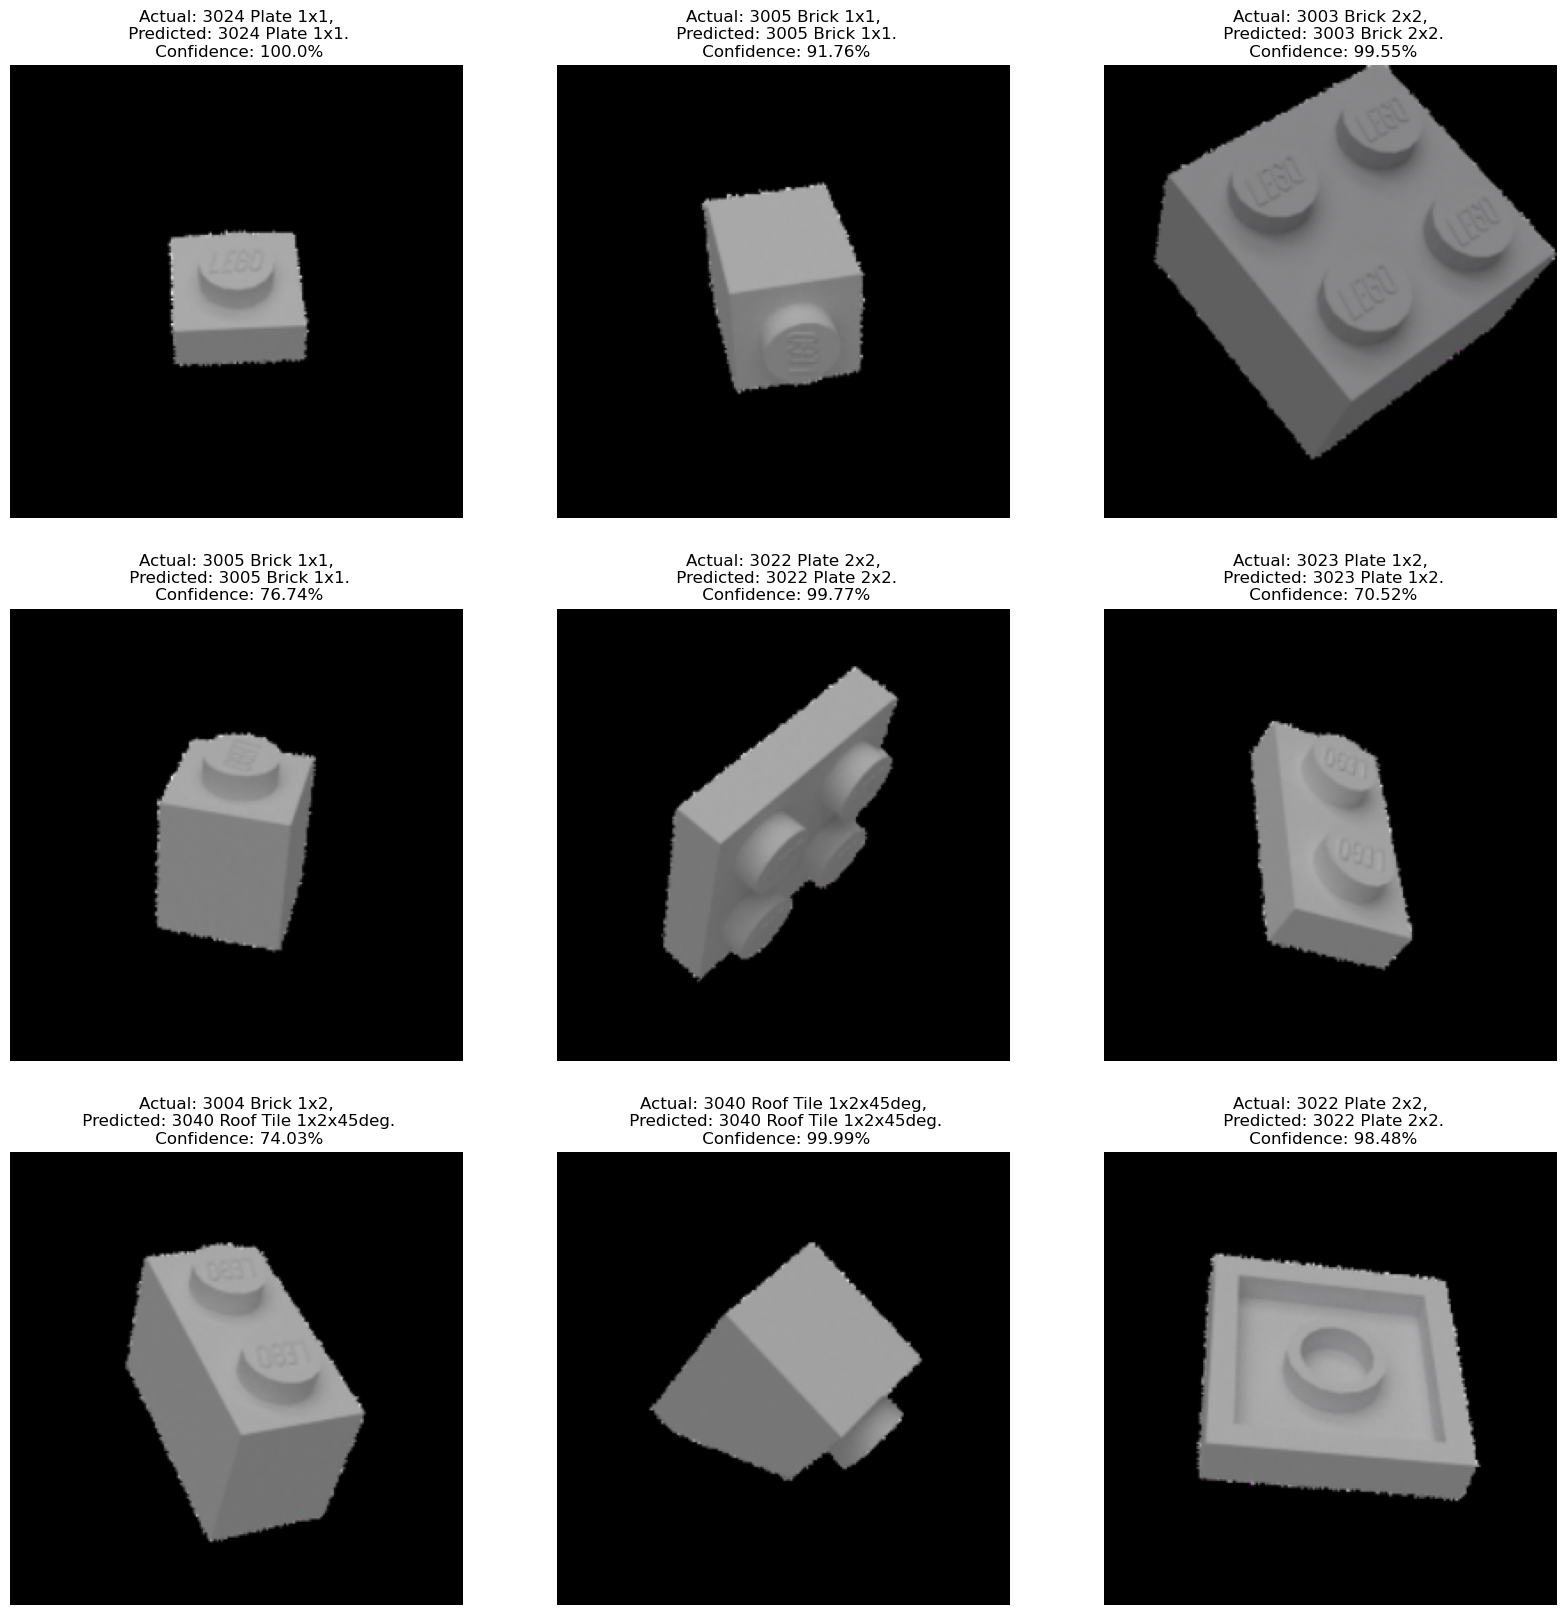

In [30]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
import os
model_version=max([int(i) for i in os.listdir("./Models") + [0]])+1
model.save(f"./Models/{model_version}")

ValueError: invalid literal for int() with base 10: 'Lego_Bricks_50'

In [176]:
model.save("./potatoes.h5")

C:\Users\udith\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
